<a href="https://www.kaggle.com/code/princelv84/brain-tumor?scriptVersionId=263623675" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Brain Tumor Prediction

**Author:** Lovnish Verma  

## **Tags**

`Image Classification` | `CNN` | `Computer Vision` | `Deep Learning`

## **Dataset**

[Brain Tumor Dataset (Yes/No)](https://www.kaggle.com/datasets/princelv84/brain-tumor-dataset-yesno-class)


In [1]:
!ls /kaggle/input/brain-tumor-dataset-yesno-class/archive

Testing  Training


In [2]:
!ls /kaggle/working

__notebook__.ipynb


In [3]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import seaborn as sns
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, models

2025-09-23 21:18:37.487150: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758662317.828988      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758662317.923179      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Dataset paths
train_dir = '/kaggle/input/brain-tumor-dataset-yesno-class/archive/Training'
test_dir = '/kaggle/input/brain-tumor-dataset-yesno-class/archive/Testing'

# Verify folder structure
print("Training folders:", os.listdir(train_dir))
print("Testing folders:", os.listdir(test_dir))

Training folders: ['No Tumor', 'Yes Tumor']
Testing folders: ['No Tumor', 'Yes Tumor']


In [5]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for testing/validation
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
# Load data from directories
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 2916 images belonging to 2 classes.
Found 705 images belonging to 2 classes.


In [7]:
# Check class distribution and mapping
print("Class indices:", train_data.class_indices)
counter = Counter(train_data.classes)
print("Training class distribution:", counter)

Class indices: {'No Tumor': 0, 'Yes Tumor': 1}
Training class distribution: Counter({0: 1595, 1: 1321})


That explains everything clearly:

* **Class indices:**

  * `No Tumor` → 0
  * `Yes Tumor` → 1

* **Training distribution:**

  * No Tumor = 1595
  * Yes Tumor = 1321
  * Slight imbalance, but not huge.



In [8]:
# Compute class weights to handle imbalance
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights_array))
print("Class weights:", class_weights)

Class weights: {0: 0.9141065830721004, 1: 1.1037093111279335}


* **Class weights:**

  ```python
  {0: 0.914, 1: 1.104}
  ```

In [9]:
# Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Reduce overfitting
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1758662336.207276      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758662336.207954      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [10]:
# Train the model
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=15,
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1758662340.989539      79 service.cc:148] XLA service 0x7cc7c8006630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758662340.991295      79 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758662340.991319      79 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758662341.382797      79 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/92 ━━━━━━━━━━━━━━━━━━━━ 10:10 7s/step - accuracy: 0.6250 - loss: 0.6684

I0000 00:00:1758662345.056548      79 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 298ms/step - accuracy: 0.7326 - loss: 0.4954 - val_accuracy: 0.9716 - val_loss: 0.0846
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 176ms/step - accuracy: 0.9510 - loss: 0.1381 - val_accuracy: 0.9660 - val_loss: 0.0922
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 173ms/step - accuracy: 0.9604 - loss: 0.0960 - val_accuracy: 0.8241 - val_loss: 0.7105
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 180ms/step - accuracy: 0.9760 - loss: 0.0872 - val_accuracy: 0.9589 - val_loss: 0.1222
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 175ms/step - accuracy: 0.9766 - loss: 0.0753 - val_accuracy: 0.9475 - val_loss: 0.2008
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 175ms/step - accuracy: 0.9783 - loss: 0.0790 - val_accuracy: 0.9050 - val_loss: 0.3487
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 180ms/step - accuracy: 0.9780 - loss: 0.0671 - val_accuracy: 0.9333 - val_loss: 0.2641
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 171ms/step - accuracy: 0.9817 - loss: 0.0595 - val_accuracy: 0.919

In [11]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_data, verbose=2)
print(f"Test Accuracy: {test_acc:.2f}")

23/23 - 1s - 56ms/step - accuracy: 0.9660 - loss: 0.1131
Test Accuracy: 0.97


In [12]:
# Predictions on test set
y_pred = model.predict(test_data)
y_pred_classes = (y_pred > 0.5).astype(int)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step


In [13]:
# Classification report
print(classification_report(test_data.classes, y_pred_classes, target_names=list(train_data.class_indices.keys())))

              precision    recall  f1-score   support

    No Tumor       0.95      1.00      0.97       405
   Yes Tumor       0.99      0.93      0.96       300

    accuracy                           0.97       705
   macro avg       0.97      0.96      0.96       705
weighted avg       0.97      0.97      0.97       705



In [14]:
# Confusion matrix
cm = confusion_matrix(test_data.classes, y_pred_classes)
cm

array([[403,   2],
       [ 22, 278]])

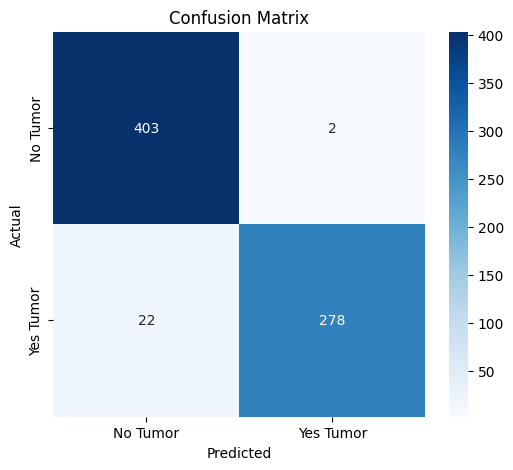

In [15]:
# Confusion matrix
cm = confusion_matrix(test_data.classes, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(train_data.class_indices.keys()), yticklabels=list(train_data.class_indices.keys()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

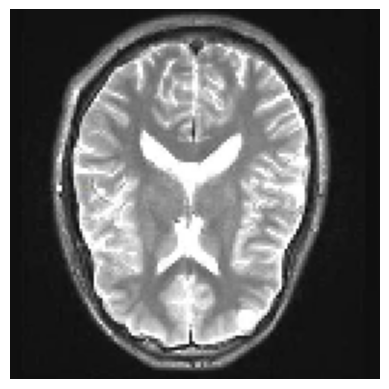

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
Predicted: No Tumor, Actual: No Tumor


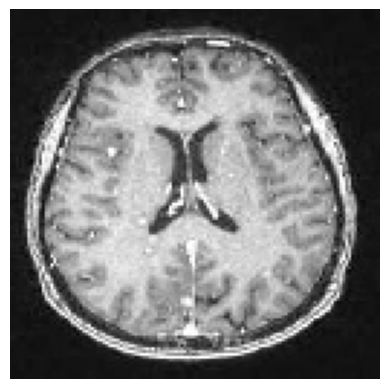

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted: No Tumor, Actual: No Tumor


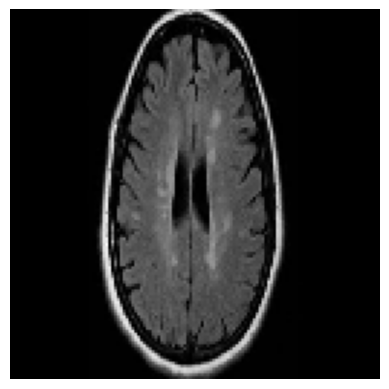

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted: No Tumor, Actual: No Tumor


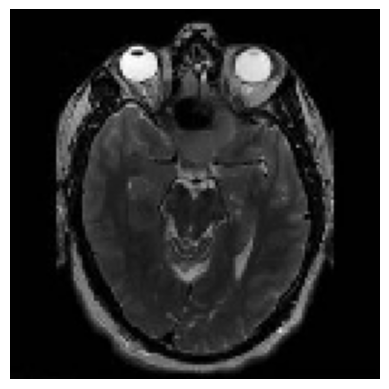

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted: No Tumor, Actual: No Tumor


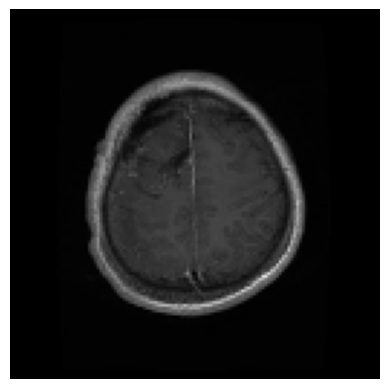

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted: Tumor, Actual: Tumor


In [16]:
# Visualize a few predictions

import random

# Pick 5 random test images
indices = random.sample(range(len(test_data.filepaths)), 5)

for i in indices:
    img_path = test_data.filepaths[i]
    img = load_img(img_path, target_size=(128,128))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    pred = model.predict(np.expand_dims(img_to_array(img)/255.0, axis=0))
    actual_class = 'Tumor' if test_data.classes[i]==1 else 'No Tumor'
    predicted_class = 'Tumor' if pred>0.5 else 'No Tumor'
    print(f"Predicted: {predicted_class}, Actual: {actual_class}")


In [17]:
# Save the model
model_save_path = '/kaggle/working/braintumor_binary.h5'
model.save(model_save_path)
print(f"Model saved successfully at {model_save_path}!")

Model saved successfully at /kaggle/working/braintumor_binary.h5!
